# Forecast The Global Household Electric Power Consumption

In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn

## Explore The Data

In [2]:
data = pd.read_csv("..\data\household_power_consumption.txt", sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
data.shape

(2075259, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


**Attribute Information:**

1. **date**: Date in format dd/mm/yyyy  
2. **time**: time in format hh:mm:ss  
3. **globalactivepower**: household global minute-averaged active power (in kilowatt)  
4. **globalreactivepower**: household global minute-averaged reactive power (in kilowatt)  
5. **voltage**: minute-averaged voltage (in volt)  
6. **global_intensity**: household global minute-averaged current intensity (in ampere)  
7. **submetering1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).  
8. **submetering2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
9. **submetering3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner  

In [5]:
data.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

There is 2075259 records from 2006-12-16 to 2010-11-26 with 25979 of missing records. We will fill them with mean-value in the future.  
We focus on forecasting the Global_active_power here, which is the **true** or **real** or **actual power** dissipated in the circuit.

## Let's Forecast !

First of all, let's revise some concept of the time series.  

Time series can be decomposed as three components, which are **drift**, **seasonal**, and **noise**

$$ y(t) = \mathrm{drift} + \mathrm{seasonal} + \mathrm{noise}. $$

- **Drift**: An overall trend, such as 
$$ y(t) = \mu t. $$
Note that the trend no need to be a linear, it can be quadratic or polynomial or whatever! 

- **Seasonality**: A periodic behavior, such as
$$ y(t) = A\sin(2\pi ft) + B\cos(2\pi ft). $$
where, $f$ is the frequency

- **Noise**: The part of the time series remaining after removing drift and seasonality. It is the residual of a model containing drift and seasonality.

Our approach will be to identify the first two terms to create a baseline model, leaving behind the residuals or noise.

**The steps to time series forecasting:**
1. Plot the time series to see if there is any overall trends and seasonality.
1. Detrend the time series by removing drift and seasonality.
1. Fit a baseline model and calculate the residuals.
1. Analyze the resulting residuals and generate features from the residuals.
1. Train a machine learning model to forecast/predict residuals and add back the baseline model.

###  1. Plot the time series to see if there is any overall trends and seasonality.

<AxesSubplot:xlabel='dt', ylabel='Minute average power kW'>

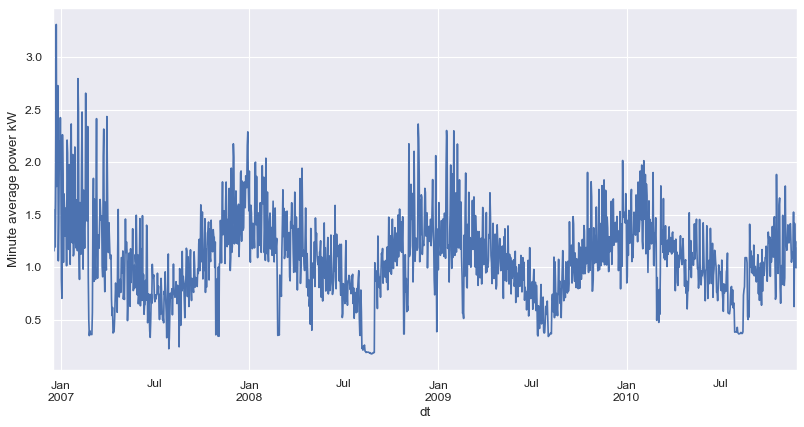

In [64]:
power = data['Global_active_power'].resample('D').mean()
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Minute average power kW')
power.plot()

According to the plots, it looks like a stationary TS with seasonality. However, we can create a simple model to capture drift, if it existing, even if we can't recognize.

In [11]:
# We can customize transformer to select the index of df
from sklearn.base import BaseEstimator, TransformerMixin

class IndexSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Return indices of a data frame for use in other estimators."""
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        indices = df.index
        return indices.values.reshape(-1, 1)

In [45]:
def ts_train_test_split(df, cutoff, target):
    """Perform a train/test split on a data frame based on a cutoff date."""
    
    ind = df.index < str(cutoff)
    
    df_train = df.loc[ind]
    df_test = df.loc[~ind]
    y_train = df.loc[ind, target]
    y_test = df.loc[~ind, target]
    
    return df_train, df_test, y_train, y_test

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

# perform train/test split
cutoff = 2010
df_train, df_test, y_train, y_test = ts_train_test_split(data, cutoff, 'Global_active_power')

# impute missing
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# construct and train pipeline
time = IndexSelector()
poly = PolynomialFeatures(degree=1)
lr = LinearRegression()
pipe = Pipeline([('indices', time),
                 ('impute', imp),
                 ('drift', poly),
                 ('regressor', lr)])
pipe.fit(df_train, y_train)

# make predictions
y_pred = pipe.predict(data)
resd = data["Global_active_power"] - y_pred
print("Test set R^2: {:g}".format(pipe.score(df_test, y_test)))

Test set R^2: -0.00159567


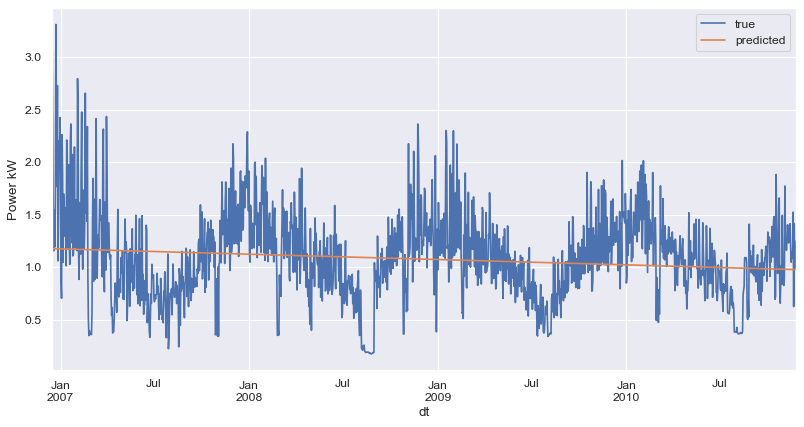

In [60]:
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
data["Global_active_power"].resample("D").mean().plot()
y_pred_df["pred_power"].resample("D").mean().plot()
plt.legend(['true', 'predicted'])

<AxesSubplot:xlabel='dt', ylabel='Power kW'>

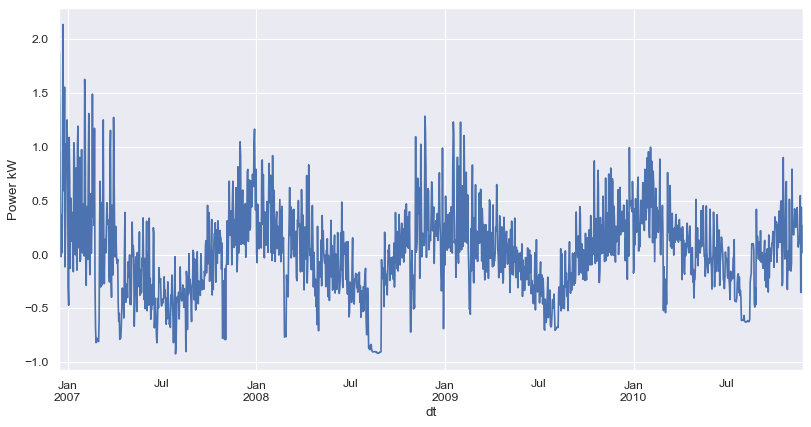

In [62]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
resd.resample("D").mean().plot()